# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
from AirControl import actions

import time
from pprint import pprint
import PIL.Image as Image
from collections import deque
import base64
import numpy as np
import matplotlib.cm as cm
from io import BytesIO
from matplotlib.pyplot import  imshow
import matplotlib.pyplot as plt
import torch
import matplotlib.animation as animation


from dqn_agent import Agent
from tqdm import tqdm

A =  actions.Actions()

agent = Agent(state_size=8, action_size=4, seed=0)
%matplotlib inline


Now play the environment and call call method `Action.get_connected` to get connected


In [2]:
# get connected to server
A.get_connected()

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [3]:

def reset():
    output = A.reset(IsOutput=True)
    A.set_audio(EnableAudio=False, IsActive=True)
    A.set_ui(ShowUIElements=True, IsActive= True)
    A.set_camera(ActiveCamera=1, IsActive=True, IsCapture=True, CaptureCamera=1, CaptureType=0,CaptureHeight=540, CaptureWidth=960)
    return output

In [4]:
def output2features(output):
    """
    output2features(output)
    Args:
        ```
        output ([type]): [description]
        >>> ([0.905434847,
        0.00182869844,
        0.000590562,
        0.0,
        0.0,
        0.021583642933333334,
        0.325318575,
        0.0460257],
        True)
        ```
    Returns:
        [type]: flight status
        [bool]: if collided
    """
    MSL = output['MSL']
    Latitude = output['Latitude']
    Longitude = output['Longitude']
    normalizedRPM =  output['CurrentRPM']/output['MaxRPM']
    normalizedPower =  output['CurrentPower']/output['MaxPower']
    normalizedSpeed = output['CurrentSpeed']/150
    pitchAngle = output['PitchAngle']
    bankAngle = output['BankAngle']
    ifCollision = output['IfCollision']
    collidedWith = output['collisionObject']
    Reward = output["Reward"]
    feature_vector = [MSL, Latitude, Longitude, normalizedRPM, normalizedPower, normalizedSpeed, pitchAngle, bankAngle]
    return np.asarray(feature_vector),Reward, ifCollision,collidedWith
    
    

Please refer to the instructions in `Deep_Q_Network.ipynb` if you would like to write your own DQN agent.  Otherwise, run the code cell below to load the solution files.

🔁 Reset Triggered , Collided with   19
🔁 Reset Triggered , Collided with   27
🔁 Reset Triggered , Collided with   38
🔁 Reset Triggered , Collided with   44
🔁 Reset Triggered , Collided with   50
🔁 Reset Triggered , Collided with   57
🔁 Reset Triggered , Collided with   62
🔁 Reset Triggered , Collided with   69
🔁 Reset Triggered , Collided with   73
🔁 Reset Triggered , Collided with   77
🔁 Reset Triggered , Collided with   82
🔁 Reset Triggered , Collided with   86
🔁 Reset Triggered , Collided with   91
🔁 Reset Triggered , Collided with   94
🔁 Reset Triggered , Collided with   97


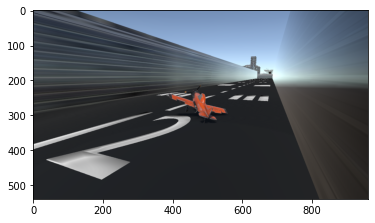

In [5]:
# watch an untrained agent
output = reset()
features,reward, ifCollided,_ = output2features(output)
eps = 1.0
frames = [] # for storing the generated images
fig = plt.figure()
while (True):
        action = agent.act(features, eps)
        pitch =  action[0]
        yaw = action[1]
        roll= action[2]
        stickyThrottle=action[3]
        # print(pitch, yaw, roll, stickyThrottle)
        output = A.step(Pitch=pitch, Yaw=yaw, Roll=roll, StickyThrottle=stickyThrottle)
        features,reward, ifCollided,collidedWith = output2features(output)
        image = output['ScreenCapture']
        if image != "":
            im = Image.open(BytesIO(base64.b64decode(image)))
            imshow(np.asarray(im))
            frames.append(im)
            # Save into a GIF file that loops forever
            frames[0].save('sample.gif', format='GIF',append_images=frames[0:],save_all=True,duration=300, loop=0)
        if ifCollided:
            print("🔁 Reset Triggered , Collided with {0} ".format(collidedWith), len(frames))
            output = reset()
        if len(frames)>=10:
            break

## Show Created GIF
![SegmentLocal](sample.gif "segment")

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Alternatively, you can skip to the next step below (**4. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

In [6]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        output = reset()
        state, reward, ifCollided = output2features(output)
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            # print(action)
            pitch =  action[0]
            yaw = action[1]
            roll= action[2]
            stickyThrottle=action[3]
            output = A.step(Pitch=pitch, Yaw=yaw, Roll=roll, StickyThrottle=stickyThrottle)
            next_state,reward,ifCollided = output2features(output)
            #reward calculation
            agent.step(state, action, reward, next_state, ifCollided)
            state = next_state
            score += reward
            if ifCollided:
                print("Collided")
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        # print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        # if i_episode % 100 == 0:
        #     print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        # if np.mean(scores_window)>=200.0:
        #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        #     torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        #     break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

/home/supatel/Games/AirControl_2021_URP/ReinforcementLearningExample/TakingOff/dqn_agent.py:105: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(Q_expected, Q_targets)


KeyboardInterrupt: 

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [4]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    state = env.reset()
    for j in range(200):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  